# Sensor Coverage (Terrain + Vegetation) 
This notebook estimates **effective sensing coverage** for every candidate sensor inside a user-drawn AOI and then **selects K sensor locations** (no gateways required) under terrain and vegetation constraints.

**Pipeline**
1. **AOI → Surfaces**: Draw AOI, fetch DEM from OpenTopography; optionally clip & integrate local **DSM/CHM** (Eaton/Palisades). Warp all rasters to **UTM meters** for geometry-correct sampling.
2. **Directional visibility**: For each candidate, compute per-azimuth openness from terrain (γ_topo) and vegetation attenuation (γ_veg), combine to **γ(θ)** and per-azimuth **effective radius** r_eff(θ).
3. **Coverage masks & metrics**: Rasterize each sensor’s coverage on a grid; record **γ̄** (mean gamma) and **A_eff** (effective area).
4. **Optimization**: Choose K sensors with a **min-separation** constraint using **random**, **greedy**, and **NSGA-III** to trade off:
   - coverage (%) of the AOI,
   - mean γ (sensing quality),
   - average pairwise spacing.
5. **Visualization & outputs**: Plot sensor contours, union coverage, and **Pareto trade-offs**; save **poster-ready** figures.

**Scenarios compared**
- **Flat** (baseline, no terrain/vegetation)
- **DEM** (terrain only)
- **DSM+CHM** (terrain + canopy attenuation)

**Key controls**: `SensorParams` (`R_m`, `az_step_deg`, `theta_topo_deg`, `h_thr_m`, `h_ref_m`, `alpha_veg`, `min_sep_m`) and `k` (number of sensors).


In [2]:
# ======================================================================
# SensorCoverage_NoGateway — terrain/vegetation-aware sensing coverage
# ======================================================================
#cell 1
import os, math, random, warnings
from dataclasses import dataclass
from typing import Tuple, List, Dict, Optional

import numpy as np
import pandas as pd

from shapely.geometry import Point, Polygon, shape
from shapely.ops import unary_union
from geopy.distance import geodesic

import rasterio
from rasterio.io import MemoryFile
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from pyproj import Transformer

import matplotlib.pyplot as plt

# Optimizers
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultMultiObjectiveTermination

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True, linewidth=140)

RANDOM_SEED = 42
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)
print(f"✅ Random seed: {RANDOM_SEED}")

# =======================
# Model + run parameters
# =======================

@dataclass
class SensorParams:
    R_m: float = 500.0           # nominal sensing radius (meters)
    az_step_deg: int = 1         # 1..5 recommended; 2deg=180 bearings
    step_m: float = 1.0         # step along each ray when sampling DSM/CHM
    sensor_height_m: float = 2.0 # height of sensing element above local surface (for horizon)
    theta_topo_deg: float = 6.0  # horizon angle threshold for "blocked" (terrain)
    h_thr_m: float = 2.0         # canopy threshold (≥2 m is vegetation)
    h_ref_m: float = 8.0        # veg density reference height for weighting
    alpha_veg: float = 0.9       # veg attenuation strength (exp mode)
    veg_mode: str = "exp"        # "exp" or "linear"
    min_sep_m: float = 400.0     # optional min separation constraint for optimizers

SP = SensorParams()

✅ Random seed: 42


In [ ]:
# =======================
# DEM/DSM/CHM manager
# =======================
#2) DEM manager 
class DEMManager:
    def __init__(self, dem_bytes: bytes):
        with MemoryFile(dem_bytes) as memfile:
            with memfile.open() as src:
                self.dem_array = src.read(1)
                self.transform = src.transform
                self.bounds = src.bounds
                self.profile = src.profile
                self.crs = src.crs
        self.shape = self.dem_array.shape
        self.slope_arr = None
        self.aspect_arr = None

        # Optional high-res surfaces
        self.dsm_array = None
        self.dsm_transform = None
        self.chm_array = None
        self.chm_transform = None
        self.chm_crs = self.crs

    def set_dsm(self, dsm_array, dsm_transform):
        self.dsm_array = dsm_array; self.dsm_transform = dsm_transform

    def set_chm(self, chm_array, chm_transform):
        self.chm_array = chm_array; self.chm_transform = chm_transform

    def degree_to_meter(self, lon, lat):
        from pyproj import Geod
        geod = Geod(ellps='WGS84')
        dx = abs(self.transform.a); dy = abs(self.transform.e)
        _, _, x_meter = geod.inv(lon, lat, lon + dx, lat)
        _, _, y_meter = geod.inv(lon, lat, lon, lat + dy)
        return abs(x_meter), abs(y_meter)

    def calculate_slope_and_aspect(self):
        center_col = self.dem_array.shape[1] // 2
        center_row = self.dem_array.shape[0] // 2
        lon0, lat0 = self.transform * (center_col, center_row)
        dx_meter, dy_meter = self.degree_to_meter(lon0, lat0)
        gy, gx = np.gradient(self.dem_array.astype(float), dy_meter, dx_meter)
        self.slope_arr = np.degrees(np.arctan(np.sqrt(gx**2 + gy**2)))
        aspect_rad = np.arctan2(-gx, gy)
        self.aspect_arr = np.degrees(aspect_rad); self.aspect_arr[self.aspect_arr < 0] += 360

    # --- samplers (DEM grid) ---
    def _sample(self, arr, tr, coord):
        col, row = ~tr * coord
        row, col = int(row), int(col)
        if 0 <= row < arr.shape[0] and 0 <= col < arr.shape[1]:
            v = arr[row, col]; 
            return float(v) if np.isfinite(v) else float("nan")
        return float("nan")

    def get_elevation(self, coord: Tuple[float, float]) -> float:
        return self._sample(self.dem_array, self.transform, coord)

    def get_surface_elevation(self, coord: Tuple[float, float]) -> float:
        if self.dsm_array is None or self.dsm_transform is None:
            return self.get_elevation(coord)
        return self._sample(self.dsm_array, self.dsm_transform, coord)

    def get_canopy_height(self, coord: Tuple[float, float]) -> float:
        if self.chm_array is None or self.chm_transform is None:
            return 0.0
        v = self._sample(self.chm_array, self.chm_transform, coord)
        return float(v) if np.isfinite(v) else 0.0

In [4]:
# =======================
# AOI + candidate grid
# =======================

def meters_per_deg(lat):
    m_per_deg_lat = 111_000.0
    m_per_deg_lon = m_per_deg_lat * math.cos(math.radians(lat))
    return m_per_deg_lon, m_per_deg_lat

def generate_coverage_grid(polygon: Polygon, grid_size: int = 60) -> List[Tuple[float, float]]:
    min_x, min_y, max_x, max_y = polygon.bounds
    xs = np.linspace(min_x, max_x, grid_size)
    ys = np.linspace(min_y, max_y, grid_size)
    pts = []
    for x in xs:
        for y in ys:
            if polygon.contains(Point(x, y)):
                pts.append((x, y))
    return pts

def sample_points_in_poly(polygon: Polygon, n_points: int) -> List[Tuple[float, float]]:
    minx, miny, maxx, maxy = polygon.bounds
    pts = []
    while len(pts) < n_points:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(p):
            pts.append((p.x, p.y))
    return pts

In [5]:
# =======================
# Directional openness & vegetation
# =======================
#cell.3 
def _step_from(coord, az_deg, step_m):
    lon0, lat0 = coord
    mlon, mlat = meters_per_deg(lat0)
    dx = math.sin(math.radians(az_deg)) * step_m
    dy = math.cos(math.radians(az_deg)) * step_m
    return (lon0 + dx / mlon, lat0 + dy / mlat)

def horizon_profile(dmgr: DEMManager, coord, radius_m, az_step_deg, step_m, sensor_h_m,
                    mode="dem", stop_at_deg=None):
    lon0, lat0 = coord
    az = np.arange(0, 360, az_step_deg, dtype=float)
    horz = np.zeros_like(az)

    def zsurf(c):
        if mode == "flat": return dmgr.get_elevation(coord)
        if mode == "dem":  return dmgr.get_elevation(c)
        if dmgr.dsm_array is not None: return dmgr.get_surface_elevation(c)
        if dmgr.chm_array is not None: return dmgr.get_elevation(c) + dmgr.get_canopy_height(c)
        return dmgr.get_elevation(c)

    z0 = zsurf(coord) + sensor_h_m
    steps = max(2, int(radius_m // step_m))
    for i, a in enumerate(az):
        max_alpha = 0.0
        C = coord
        for s in range(1, steps + 1):
            C = _step_from(C, a, step_m)
            dist = s * step_m
            z_here = zsurf(C) + sensor_h_m
            alpha = math.degrees(math.atan2(z_here - z0, dist))
            if alpha > max_alpha:
                max_alpha = alpha
                if stop_at_deg is not None and max_alpha >= stop_at_deg:
                    break  # already blocked for our thresholding needs
        horz[i] = max(0.0, max_alpha)
    return az, horz

def gamma_topo_az(dmgr, coord, SP: SensorParams, mode="dem"):
    stop_at = SP.theta_topo_deg + 0.25  # small margin
    az, horz = horizon_profile(dmgr, coord, SP.R_m, SP.az_step_deg, SP.step_m,
                               SP.sensor_height_m, mode=mode, stop_at_deg=stop_at)
    open_mask = (horz <= SP.theta_topo_deg)
    g_topo = open_mask.astype(float)
    return az, g_topo, horz


def vegetation_gamma_az(dmgr, coord, SP: SensorParams):
    """
    Per-azimuth vegetation attenuation using CHM along the ray:
      V(θ) = mean( min(1, CHM/h_ref) for CHM>=h_thr )  within radius
      γ_veg(θ) = exp(-α V)    [or linear 1 - α V]
    """
    if dmgr.chm_array is None:
        # no vegetation data available
        az = np.arange(0, 360, SP.az_step_deg, dtype=float)
        return az, np.ones_like(az, dtype=float), np.zeros_like(az, dtype=float)

    lon0, lat0 = coord
    az = np.arange(0, 360, SP.az_step_deg, dtype=float)
    V = np.zeros_like(az, dtype=float)

    steps = max(2, int(SP.R_m // SP.step_m))
    for i, a in enumerate(az):
        vals = []
        C = coord
        for s in range(1, steps + 1):
            C = _step_from(C, a, SP.step_m)
            ch = dmgr.get_canopy_height(C)
            if ch >= SP.h_thr_m:
                vals.append(min(1.0, ch / SP.h_ref_m))
        V[i] = float(np.mean(vals)) if len(vals) else 0.0

    if SP.veg_mode == "linear":
        g = np.clip(1.0 - SP.alpha_veg * V, 0.0, 1.0)
    else:
        g = np.exp(-SP.alpha_veg * V)
    return az, g, V

In [6]:
# =======================
# Cell 3.5 — UTM warp + bilinear samplers + meter-based profiles
# =======================
from rasterio.warp import calculate_default_transform
from pyproj import CRS, Transformer



def _utm_crs_for_ll(lon, lat):
    zone = int((lon + 180)//6) + 1
    return CRS.from_epsg(32600+zone if lat >= 0 else 32700+zone)

def warp_surfaces_to_utm(dmgr: DEMManager, aoi_poly: Polygon, target_res_m=2.0):
    """Warp DEM/DSM/CHM to a single aligned UTM grid (meters)."""
    cx, cy = aoi_poly.centroid.x, aoi_poly.centroid.y
    utm = _utm_crs_for_ll(cx, cy)

    # Base DEM target grid at requested resolution
    transform, width, height = calculate_default_transform(
        dmgr.crs, utm,
        dmgr.dem_array.shape[1], dmgr.dem_array.shape[0],
        *dmgr.bounds, resolution=target_res_m
    )

    def _rp(src_arr, src_tr, src_crs):
        dst = np.empty((height, width), dtype=np.float32)
        reproject(
            source=src_arr, destination=dst,
            src_transform=src_tr, src_crs=src_crs,
            dst_transform=transform, dst_crs=utm,
            resampling=Resampling.bilinear, num_threads=2
        )
        return dst

    dem_utm = _rp(dmgr.dem_array, dmgr.transform, dmgr.crs)
    dsm_utm = _rp(dmgr.dsm_array, dmgr.dsm_transform, getattr(dmgr, "dsm_crs", dmgr.crs)) if dmgr.dsm_array is not None else None
    chm_utm = _rp(dmgr.chm_array, dmgr.chm_transform, getattr(dmgr, "chm_crs", dmgr.crs)) if dmgr.chm_array is not None else None

    # stash on manager
    dmgr.utm_crs = utm
    dmgr.utm_transform = transform
    dmgr.dem_utm = dem_utm
    dmgr.dsm_utm = dsm_utm
    dmgr.chm_utm = chm_utm
    dmgr._ll2utm = Transformer.from_crs("EPSG:4326", utm, always_xy=True)
    dmgr._utm2ll = Transformer.from_crs(utm, "EPSG:4326", always_xy=True)
    print(f"✅ Surfaces warped to UTM {utm.to_string()} @ ~{abs(transform.a):.2f} m")

def _bilinear(arr, tr, x, y):
    """Bilinear sample at UTM x,y (meters) from array+affine tr."""
    if arr is None: return np.nan
    colf, rowf = (~tr) * (x, y)
    r0, c0 = int(np.floor(rowf)), int(np.floor(colf))
    if r0 < 0 or c0 < 0 or r0+1 >= arr.shape[0] or c0+1 >= arr.shape[1]:
        return np.nan
    dr, dc = rowf - r0, colf - c0
    a = arr[r0,   c0  ]; b = arr[r0,   c0+1]
    c = arr[r0+1, c0  ]; d = arr[r0+1, c0+1]
    return (a*(1-dc)*(1-dr) + b*dc*(1-dr) + c*(1-dc)*dr + d*dc*dr)

def elev_surface_at_utm(dmgr, x, y, mode):
    if mode == "flat":
        return _bilinear(dmgr.dem_utm, dmgr.utm_transform, x, y)
    if mode == "dem":
        return _bilinear(dmgr.dem_utm, dmgr.utm_transform, x, y)
    # dsm_chm: prefer DSM; else DEM + CHM
    if dmgr.dsm_utm is not None:
        return _bilinear(dmgr.dsm_utm, dmgr.utm_transform, x, y)
    base = _bilinear(dmgr.dem_utm, dmgr.utm_transform, x, y)
    ch   = 0.0 if dmgr.chm_utm is None else _bilinear(dmgr.chm_utm, dmgr.utm_transform, x, y)
    return base + max(0.0, ch)

def horizon_and_veg_profiles_utm(dmgr, x0, y0, SP: SensorParams, mode="dem"):
    """
    Meters-based profiles with distance-limited topography.
    Returns (az, gamma_az, g_topo, horizon_deg) where:
      - g_topo(θ) = (r_open/R)^2, r_open = farthest distance with alpha <= theta_thr
      - gamma_az(θ) = g_topo(θ) * g_veg(θ)
    """
    az = np.arange(0, 360, SP.az_step_deg, dtype=float)
    steps = max(2, int(SP.R_m // SP.step_m))
    s = np.linspace(SP.step_m, steps*SP.step_m, steps, dtype=float)  # distances (m)
    vx = np.sin(np.deg2rad(az)); vy = np.cos(np.deg2rad(az))

    # sensor reference height
    z0 = elev_surface_at_utm(dmgr, x0, y0, mode) + SP.sensor_height_m

    horizon = np.zeros_like(az, dtype=float)
    g_topo  = np.zeros_like(az, dtype=float)
    g_veg   = np.ones_like(az,  dtype=float)

    theta_thr = SP.theta_topo_deg
    R = SP.R_m

    for i in range(az.size):
        xs = x0 + vx[i] * s
        ys = y0 + vy[i] * s

        # surface along the ray (same surface used for horizon)
        z_s = np.array([elev_surface_at_utm(dmgr, xs[k], ys[k], mode) for k in range(steps)], dtype=float) + SP.sensor_height_m
        alpha = np.degrees(np.arctan2(z_s - z0, s))  # angle to each point along ray

        horizon[i] = np.nanmax(alpha)

        # ---- distance-limited openness: farthest distance still under the threshold
        ok = np.where(alpha <= theta_thr)[0]
        if ok.size == 0:
            r_open = 0.0
        else:
            r_open = float(s[ok[-1]])  # farthest visible point along this azimuth

        # fraction of area open due to topography
        g_topo[i] = (r_open / R) ** 2

        # ---- vegetation attenuation (ONLY for dsm_chm mode)
        if mode == "dsm_chm" and dmgr.chm_utm is not None and r_open > 0:  
            ch = np.array([_bilinear(dmgr.chm_utm, dmgr.utm_transform, xs[k], ys[k]) for k in range(steps)], dtype=float)
            ch = np.nan_to_num(ch, nan=0.0)
            use = (s <= r_open) & (ch >= SP.h_thr_m)
            if np.any(use):
                v = np.minimum(1.0, ch[use] / SP.h_ref_m)  # 0..1 density surrogate
                dens = float(np.mean(v))                   # mean along visible path
            else:
                dens = 0.0
            g_veg[i] = np.exp(-SP.alpha_veg * dens) if SP.veg_mode != "linear" else np.clip(1.0 - SP.alpha_veg * dens, 0.0, 1.0)
        else:
            g_veg[i] = 1.0

    gamma = np.clip(g_topo * g_veg, 0.0, 1.0)
    return az, gamma, g_topo, horizon

In [7]:
# =======================
# Combine to directional γ(θ) and effective reach
# =======================
#cell 4
def directional_gamma(dmgr, coord, scenario: str, SP: SensorParams):
    """
    scenario: 'flat' | 'dem' | 'dsm_chm'
    Uses UTM (meters) if available; otherwise falls back to your lon/lat path.
    """
    A0 = math.pi * SP.R_m**2

    if hasattr(dmgr, "utm_crs"):
        x0, y0 = dmgr._ll2utm.transform(coord[0], coord[1])
        if scenario == "flat":
            az = np.arange(0, 360, SP.az_step_deg, dtype=float)
            gamma_az = np.ones_like(az); g_topo = np.ones_like(az); g_veg = np.ones_like(az); horz = np.zeros_like(az)
        elif scenario == "dem":
            az, gamma_az, g_topo, horz = horizon_and_veg_profiles_utm(dmgr, x0, y0, SP, mode="dem")
            g_veg = np.ones_like(az)
        elif scenario == "dsm_chm":
            az, gamma_az, g_topo, horz = horizon_and_veg_profiles_utm(dmgr, x0, y0, SP, mode="dsm_chm")
            g_veg = np.clip(gamma_az / np.maximum(g_topo, 1e-6), 0, 1)
        else:
            raise ValueError("scenario must be 'flat'|'dem'|'dsm_chm'")
    else:
        # Fallback: your existing lon/lat implementations
        if scenario == "flat":
            az = np.arange(0, 360, SP.az_step_deg, dtype=float)
            g_topo = np.ones_like(az); g_veg = np.ones_like(az); horz = np.zeros_like(az)
        elif scenario == "dem":
            az, g_topo, horz = gamma_topo_az(dmgr, coord, SP, mode="dem")
            g_veg = np.ones_like(az)
        elif scenario == "dsm_chm":
            az, g_topo, horz = gamma_topo_az(dmgr, coord, SP, mode="dsm_chm")
            _, g_veg, _ = vegetation_gamma_az(dmgr, coord, SP)
        else:
            raise ValueError("scenario must be 'flat'|'dem'|'dsm_chm'")
        gamma_az = np.clip(g_topo * g_veg, 0.0, 1.0)

    gamma_mean = float(np.nanmean(gamma_az))
    Aeff = A0 * gamma_mean
    r_eff = SP.R_m * np.sqrt(gamma_az)
    return {
        "az": az, "gamma_az": gamma_az, "g_topo": g_topo, "g_veg": g_veg,
        "horizon_deg": horz, "A0_m2": A0, "Aeff_m2": Aeff, "gamma_mean": gamma_mean, "r_eff": r_eff
    }

def coverage_mask_for_sensor(coord, cov_grid, dirpack, SP: SensorParams, dmgr: DEMManager=None):
    """Azimuth/distance in meters using UTM if available to avoid angle/scale bias."""
    az = dirpack["az"]; r_eff = dirpack["r_eff"]
    mask = np.zeros(len(cov_grid), dtype=bool)

    if dmgr is not None and hasattr(dmgr, "utm_crs"):
        x0, y0 = dmgr._ll2utm.transform(coord[0], coord[1])
        # transform all grid points at once
        xs, ys = zip(*[dmgr._ll2utm.transform(x, y) for (x, y) in cov_grid])
        xs = np.asarray(xs); ys = np.asarray(ys)
        dx = xs - x0; dy = ys - y0
        d  = np.hypot(dx, dy)
        az_pt = (np.degrees(np.arctan2(dx, dy)) + 360.0) % 360.0
    else:
        # fallback: your lat/lon meters-per-deg method
        lon0, lat0 = coord
        mlon, mlat = meters_per_deg(lat0)
        dx_m = (np.array([p[0] for p in cov_grid]) - lon0) * mlon
        dy_m = (np.array([p[1] for p in cov_grid]) - lat0) * mlat
        d = np.hypot(dx_m, dy_m)
        az_pt = (np.degrees(np.arctan2(dx_m, dy_m)) + 360.0) % 360.0

    # bin compare
    k = (np.round(az_pt / SP.az_step_deg).astype(int)) % len(az)
    mask = d <= (r_eff[k] + 1e-9)
    return mask

In [8]:
# =======================
# Candidate search & scenario packs
# =======================
#cell 5
def build_sensor_candidates(aoi: Polygon, mode="grid", grid_size=30, n_random=400):
    if mode == "grid":
        return generate_coverage_grid(aoi, grid_size=grid_size)
    return sample_points_in_poly(aoi, n_random)

def precompute_scenario(
    aoi: Polygon, dmgr: DEMManager, scenario: str, SP: SensorParams,
    candidate_mode="grid", grid_size=30, n_random=400, cov_grid_size=80
):
    """
    Returns: dict with keys
      'candidates' : list[(lon,lat)]
      'cov_grid'   : list[(lon,lat)]
      'dirpacks'   : list[dict per candidate]
      'masks'      : np.ndarray [N_candidates, N_grid] bool
      'metrics'    : DataFrame per candidate (gamma_mean, Aeff, etc.)
    """
    candidates = build_sensor_candidates(aoi, mode=candidate_mode, grid_size=grid_size, n_random=n_random)
    cov_grid   = generate_coverage_grid(aoi, grid_size=cov_grid_size)

    dirpacks, masks, rows = [], [], []
    for i, c in enumerate(candidates):
        dp = directional_gamma(dmgr, c, scenario, SP)
        dirpacks.append(dp)
        mask = coverage_mask_for_sensor(c, cov_grid, dp, SP)
        masks.append(mask)
        rows.append({
            "lon": c[0], "lat": c[1],
            "gamma_mean": dp["gamma_mean"],
            "Aeff_m2": dp["Aeff_m2"]
        })
    masks = np.vstack(masks).astype(bool)
    meta = pd.DataFrame(rows)
    return {"candidates": candidates, "cov_grid": cov_grid, "dirpacks": dirpacks, "masks": masks, "metrics": meta}

In [9]:
# =======================
# Dynamic coverage contour helper (for plotting)
# =======================
#cell 6
def coverage_contour_lonlat(coord, dirpack, SP: SensorParams):
    lon0, lat0 = coord
    pts = []
    az = dirpack["az"]; r_eff = dirpack["r_eff"]
    mlon, mlat = meters_per_deg(lat0)
    for k, a in enumerate(az):
        d = r_eff[k]
        dx = math.sin(math.radians(a)) * d
        dy = math.cos(math.radians(a)) * d
        lon = lon0 + dx / mlon
        lat = lat0 + dy / mlat
        pts.append((lon, lat))
    pts.append(pts[0])
    return pts

def plot_single_sensor_contour(coord, dirpack, title="Dynamic coverage (r_eff)"):
    poly_pts = coverage_contour_lonlat(coord, dirpack, SP)
    xs = [p[0] for p in poly_pts]; ys = [p[1] for p in poly_pts]
    plt.figure(figsize=(5,5))
    plt.plot(xs, ys, lw=2)
    plt.scatter([coord[0]], [coord[1]], s=30)
    plt.gca().set_aspect('equal', 'box')
    plt.title(title); plt.xlabel("lon"); plt.ylabel("lat"); plt.tight_layout(); plt.show()

In [ ]:
# =======================
# Optimizers over candidate set  (weighted + fair)
# =======================
#cell 7

def union_coverage(mask_rows: np.ndarray) -> float:
    """% of cov_grid covered by union of selected sensors."""
    if mask_rows.size == 0:
        return 0.0
    return 100.0 * float(np.mean(np.any(mask_rows, axis=0)))

# -------- shared helpers --------
def _prep_optimizer_data(packs):
    """Pull common matrices once so all optimizers see the same data."""
    masks   = packs["masks"]
    metrics = packs["metrics"].reset_index(drop=True).copy()
    coords  = list(zip(metrics.lon.values, metrics.lat.values))

    # pairwise distances (meters)
    n = len(coords)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            d = geodesic((coords[i][1], coords[i][0]), (coords[j][1], coords[j][0])).meters
            D[i, j] = D[j, i] = d
    Dmax = float(np.max(D)) if n > 1 else 1.0
    return masks, metrics, coords, D, Dmax

def _feasible(idxs, D, min_sep):
    """All pairwise distances ≥ min_sep?"""
    idxs = list(map(int, idxs))
    for a in range(len(idxs)):
        for b in range(a+1, len(idxs)):
            if D[idxs[a], idxs[b]] < min_sep:
                return False
    return True

def _evaluate_idxs(idxs, masks, metrics, D):
    """Compute the 3 objectives for a chosen index set."""
    idxs = list(map(int, idxs))
    cov   = union_coverage(masks[idxs]) if len(idxs) else 0.0
    gmean = float(metrics.loc[idxs, "gamma_mean"].mean()) if len(idxs) else 0.0
    if len(idxs) > 1:
        pairs = [D[i, j] for i in idxs for j in idxs if j > i]
        mean_d = float(np.mean(pairs)) if pairs else 0.0
    else:
        mean_d = 0.0
    return cov, gmean, mean_d

def _scalar_score(cov, gmean, mean_d, Dmax, weights):
    """Weighted scalarized utility in [0, 1+]. Normalize each term first."""
    w_cov, w_g, w_d = np.asarray(weights, dtype=float)
    w_sum = w_cov + w_g + w_d
    if w_sum <= 0:
        w_cov, w_g, w_d = 1.0, 0.0, 0.0
        w_sum = 1.0
    w_cov, w_g, w_d = w_cov / w_sum, w_g / w_sum, w_d / w_sum

    cov_n  = np.clip(cov / 100.0, 0.0, 1.0)     # 0..1
    g_n    = np.clip(gmean, 0.0, 1.0)           # 0..1
    d_n    = 0.0 if Dmax <= 0 else np.clip(mean_d / Dmax, 0.0, 1.0)
    return w_cov * cov_n + w_g * g_n + w_d * d_n

# -------- RANDOM (weighted + constrained) --------
def random_select(packs, k: int, SP: SensorParams, weights=(0.80, 0.15, 0.05), trials=300):
    masks, metrics, coords, D, Dmax = _prep_optimizer_data(packs)
    n = len(coords)
    best = None
    for _ in range(trials):
        idxs = np.random.choice(n, size=k, replace=False)
        if not _feasible(idxs, D, SP.min_sep_m):
            continue
        cov, g, md = _evaluate_idxs(idxs, masks, metrics, D)
        score = _scalar_score(cov, g, md, Dmax, weights)
        if best is None or score > best[0]:
            best = (score, idxs, cov, g, md)
    # fallback: if no feasible sample found, return the best coverage set ignoring sep
    if best is None:
        idxs = np.random.choice(n, size=k, replace=False)
        cov, g, md = _evaluate_idxs(idxs, masks, metrics, D)
        best = (_scalar_score(cov, g, md, Dmax, weights), idxs, cov, g, md)
    return {"idxs": best[1], "coverage_pct": float(best[2]), "F": np.array([-best[2], -best[3], -best[4]])}

# -------- GREEDY (weighted + constrained) --------
def greedy_select(packs, k: int, SP: SensorParams, weights=(0.80, 0.15, 0.05)):
    masks, metrics, coords, D, Dmax = _prep_optimizer_data(packs)
    n = len(coords)
    selected = []
    best_cov = 0.0
    for _ in range(k):
        best = None
        for i in range(n):
            if i in selected:
                continue
            # respect min-separation vs current set
            ok = all(D[i, j] >= SP.min_sep_m for j in selected)
            if not ok:
                continue
            idxs_try = selected + [i]
            cov, g, md = _evaluate_idxs(idxs_try, masks, metrics, D)
            score = _scalar_score(cov, g, md, Dmax, weights)
            if (best is None) or (score > best[0]):
                best = (score, i, cov, g, md)
        if best is None:
            break
        selected.append(best[1])
        best_cov = best[2]
    cov, g, md = _evaluate_idxs(selected, masks, metrics, D)
    return {"idxs": np.array(selected), "coverage_pct": float(cov), "F": np.array([-cov, -g, -md])}

# -------- NSGA-III (weighted selection from Pareto front) --------
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultMultiObjectiveTermination

def nsga_select(packs, k: int, SP: SensorParams, max_gen=100, weights=(0.80, 0.15, 0.05)):
    masks, metrics, coords, D, Dmax = _prep_optimizer_data(packs)
    n = len(coords)

    class SensorPlace(Problem):
        def __init__(self):
            super().__init__(n_var=k, n_obj=3, n_constr=int(k*(k-1)/2), xl=0, xu=n-1, vtype=int)

        def _evaluate(self, X, out, *args, **kwargs):
            m = X.shape[0]
            F = np.zeros((m, 3), dtype=float)
            G = np.zeros((m, int(k*(k-1)/2)), dtype=float)
            for r in range(m):
                idxs = list(map(int, X[r]))
                # duplicates → heavy penalty
                if len(set(idxs)) != len(idxs):
                    F[r, :] = 1e6; G[r, :] = 1e6; continue
                cov, g, md = _evaluate_idxs(idxs, masks, metrics, D)
                # objectives (to MINIMIZE)
                F[r, 0] = -cov      # maximize coverage
                F[r, 1] = -g        # maximize mean gamma
                F[r, 2] = -md       # maximize spacing
                # constraints: min separation
                gi = 0
                for a in range(k):
                    for b in range(a+1, k):
                        G[r, gi] = max(0.0, SP.min_sep_m - D[idxs[a], idxs[b]])
                        gi += 1
            out["F"] = F; out["G"] = G

    # NSGA-III run
    ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=8)
    algorithm = NSGA3(ref_dirs=ref_dirs, pop_size=len(ref_dirs), eliminate_duplicates=True)
    termination = DefaultMultiObjectiveTermination(xtol=1e-8, cvtol=1e-6, ftol=0.005, period=20, n_max_gen=max_gen)
    res = minimize(SensorPlace(), algorithm, termination, seed=RANDOM_SEED, verbose=False)

    # feasible subset
    feas = np.where(np.all(res.G <= 1e-9, axis=1))[0] if res.G is not None else np.arange(len(res.X))
    if len(feas) == 0:
        feas = np.where(np.all(res.G <= 0.0, axis=1))[0]

    F = res.F[feas]; X = res.X[feas]
    # weighted "distance to ideal" in normalized space  (Option B)
    ideal = F.min(axis=0); nadir = F.max(axis=0)
    norm  = (F - ideal) / (nadir - ideal + 1e-12)
    w     = np.asarray(weights, dtype=float)
    w     = w / (np.sum(w) + 1e-12)
    d     = np.sqrt(np.sum((w * norm) ** 2, axis=1))
    j     = int(np.argmin(d))

    idxs = X[j].astype(int)
    cov  = -F[j, 0]
    return {"idxs": idxs, "coverage_pct": float(cov), "F": F[j], "weights": tuple(w)}

In [ ]:
import pyproj
from shapely.ops import transform as shapely_transform
from shapely.geometry import mapping, Point
import os
from pathlib import Path
#cell 8

# --- CRS-aware sampling for DSM/CHM in DEMManager (no globals referenced) ---
from pyproj import Transformer

def _ensure_tf_cache(self):
    if getattr(self, "_tf_ll2dsm", None) is None:
        crs = getattr(self, "dsm_crs", self.crs)
        self._tf_ll2dsm = (Transformer.from_crs("EPSG:4326", crs, always_xy=True)
                           if crs and str(crs).lower() != "epsg:4326" else None)
    if getattr(self, "_tf_ll2chm", None) is None:
        crs = getattr(self, "chm_crs", self.crs)
        self._tf_ll2chm = (Transformer.from_crs("EPSG:4326", crs, always_xy=True)
                           if crs and str(crs).lower() != "epsg:4326" else None)

def _sample_ll_cached(arr, transform, transformer, lon, lat):
    if arr is None or transform is None:
        return float("nan")
    if transformer is not None:
        x, y = transformer.transform(lon, lat)
    else:
        x, y = lon, lat
    colf, rowf = (~transform) * (x, y)
    r, c = int(rowf), int(colf)
    if 0 <= r < arr.shape[0] and 0 <= c < arr.shape[1]:
        v = arr[r, c]
        return float(v) if np.isfinite(v) else float("nan")
    return float("nan")

def _get_surface_elevation_fast(self, coord):
    _ensure_tf_cache(self)
    if getattr(self, "dsm_array", None) is None:
        return self.get_elevation(coord)
    return _sample_ll_cached(self.dsm_array, self.dsm_transform, self._tf_ll2dsm, coord[0], coord[1])

def _get_canopy_height_fast(self, coord):
    _ensure_tf_cache(self)
    if getattr(self, "chm_array", None) is None:
        return 0.0
    v = _sample_ll_cached(self.chm_array, self.chm_transform, self._tf_ll2chm, coord[0], coord[1])
    return float(v) if np.isfinite(v) else 0.0

DEMManager.get_surface_elevation = _get_surface_elevation_fast
DEMManager.get_canopy_height    = _get_canopy_height_fast
print("✅ Fast DSM/CHM samplers installed.")

def find_chm_dataset_for_aoi(aoi_poly):
    """Find which CHM dataset (Eaton or Palisades) best covers the AOI - FIXED VERSION"""
    import rasterio
    from rasterio.warp import transform_bounds
    from shapely.geometry import box
    
    eaton_files = {
        'chm': 'EatonCHM.tif',
        'dsm': 'Eatonoutput.dsm.tif', 
        'dtm': 'Eatonoutput.dtm.tif'
    }
    
    palisades_files = {
        'chm': 'palisadesCHM.tif',
        'dsm': 'palisadesoutput.dsm.tif',
        'dtm': 'palisadesoutput.dtm.tif'
    }
    
    eaton_exists = all(os.path.exists(f) for f in eaton_files.values())
    palisades_exists = all(os.path.exists(f) for f in palisades_files.values())
    
    print(f"📁 Eaton files available: {eaton_exists}")
    print(f"📁 Palisades files available: {palisades_exists}")
    
    if not eaton_exists and not palisades_exists:
        print("❌ No CHM datasets found!")
        return None, None
    
    if aoi_poly is None:
        # No AOI provided, return first available dataset
        if eaton_exists:
            return "Eaton", eaton_files
        else:
            return "Palisades", palisades_files
    
    # AOI provided - ACTUALLY CHECK COVERAGE (this was missing!)
    centroid = aoi_poly.centroid
    aoi_bounds = aoi_poly.bounds
    print(f"🎯 AOI center: {centroid.x:.4f}, {centroid.y:.4f}")
    
    coverage_results = {}
    
    # Check Eaton coverage if files exist
    if eaton_exists:
        try:
            with rasterio.open(eaton_files['chm']) as src:
                chm_bounds_4326 = transform_bounds(src.crs, 'EPSG:4326', *src.bounds)
                chm_minx, chm_miny, chm_maxx, chm_maxy = chm_bounds_4326
                aoi_minx, aoi_miny, aoi_maxx, aoi_maxy = aoi_bounds
                
                # Check for overlap
                overlap_x = not (aoi_maxx < chm_minx or aoi_minx > chm_maxx)
                overlap_y = not (aoi_maxy < chm_miny or aoi_miny > chm_maxy)
                has_overlap = overlap_x and overlap_y
                
                if has_overlap:
                    overlap_minx = max(aoi_minx, chm_minx)
                    overlap_miny = max(aoi_miny, chm_miny)
                    overlap_maxx = min(aoi_maxx, chm_maxx)
                    overlap_maxy = min(aoi_maxy, chm_maxy)
                    overlap_poly = box(overlap_minx, overlap_miny, overlap_maxx, overlap_maxy)
                    overlap_percent = (overlap_poly.area / aoi_poly.area) * 100
                else:
                    overlap_percent = 0
                
                coverage_results['Eaton'] = {
                    'files': eaton_files,
                    'coverage': overlap_percent,
                    'has_overlap': has_overlap
                }
                
        except Exception as e:
            print(f"⚠️ Error checking Eaton coverage: {e}")
            coverage_results['Eaton'] = {'files': eaton_files, 'coverage': 0, 'has_overlap': False}
    
    # Check Palisades coverage if files exist
    if palisades_exists:
        try:
            with rasterio.open(palisades_files['chm']) as src:
                chm_bounds_4326 = transform_bounds(src.crs, 'EPSG:4326', *src.bounds)
                chm_minx, chm_miny, chm_maxx, chm_maxy = chm_bounds_4326
                aoi_minx, aoi_miny, aoi_maxx, aoi_maxy = aoi_bounds
                
                # Check for overlap
                overlap_x = not (aoi_maxx < chm_minx or aoi_minx > chm_maxx)
                overlap_y = not (aoi_maxy < chm_miny or aoi_miny > chm_maxy)
                has_overlap = overlap_x and overlap_y
                
                if has_overlap:
                    overlap_minx = max(aoi_minx, chm_minx)
                    overlap_miny = max(aoi_miny, chm_miny)
                    overlap_maxx = min(aoi_maxx, chm_maxx)
                    overlap_maxy = min(aoi_maxy, chm_maxy)
                    overlap_poly = box(overlap_minx, overlap_miny, overlap_maxx, overlap_maxy)
                    overlap_percent = (overlap_poly.area / aoi_poly.area) * 100
                else:
                    overlap_percent = 0
                
                coverage_results['Palisades'] = {
                    'files': palisades_files,
                    'coverage': overlap_percent,
                    'has_overlap': has_overlap
                }
                
        except Exception as e:
            print(f"⚠️ Error checking Palisades coverage: {e}")
            coverage_results['Palisades'] = {'files': palisades_files, 'coverage': 0, 'has_overlap': False}
    
    # Select the dataset with the best coverage
    best_dataset = None
    best_coverage = 0
    best_files = None
    
    for dataset_name, result in coverage_results.items():
        if result['has_overlap'] and result['coverage'] > best_coverage:
            best_coverage = result['coverage']
            best_dataset = dataset_name
            best_files = result['files']
    
    if best_dataset:
        print(f"✅ Selected {best_dataset} dataset ({best_coverage:.1f}% coverage)")
        return best_dataset, best_files
    else:
        # No overlap found, return None to avoid the error
        print("❌ No datasets overlap with AOI!")
        return None, None

def process_opentopo_chm_for_wsn(aoi_poly, dem_manager):
    """Process OpenTopography CHM data and integrate with DEMManager for WSN analysis"""
    print("🔄 Processing OpenTopography CHM data for WSN analysis...")
    
    dataset_name, dataset_files = find_chm_dataset_for_aoi(aoi_poly)
    
    if dataset_files is None:
        print("❌ No CHM datasets available!")
        return None
    
    print(f"📂 Using {dataset_name} dataset")
    
    try:
        chm_file = dataset_files['chm']
        dsm_file = dataset_files['dsm'] 
        
        print(f"🌲 Loading CHM: {chm_file}")
        print(f"📡 Loading DSM: {dsm_file}")
        
        # Load and Mask CHM to AOI
        with rasterio.open(chm_file) as chm_src:
            chm_crs = chm_src.crs
            print(f"📡 CHM CRS: {chm_crs}")
            print(f"📡 CHM resolution: {abs(chm_src.transform.a):.2f}m")
            
            if aoi_poly is not None:
                print("🎯 Masking CHM to AOI bounds...")
                aoi_proj = reproject_aoi_to_raster(aoi_poly, chm_crs)
                chm_out, chm_transform = mask(chm_src, [mapping(aoi_proj)], crop=True)
                chm_data = chm_out[0]
                nodata = chm_src.nodata if chm_src.nodata is not None else -999999.0
                print("✅ Masked CHM to AOI bounds.")
                print(f"   Cropped CHM shape: {chm_data.shape}")
            else:
                chm_data = chm_src.read(1)
                chm_transform = chm_src.transform
                nodata = chm_src.nodata if chm_src.nodata is not None else -999999.0
        
        # Load and Mask DSM to AOI
        with rasterio.open(dsm_file) as dsm_src:
            if aoi_poly is not None:
                aoi_proj = reproject_aoi_to_raster(aoi_poly, dsm_src.crs)
                dsm_out, dsm_transform = mask(dsm_src, [mapping(aoi_proj)], crop=True)
                dsm_data = dsm_out[0]
                print(f"   Cropped DSM shape: {dsm_data.shape}")
            else:
                dsm_data = dsm_src.read(1)
                dsm_transform = dsm_src.transform
        
        # Clean up nodata values
        chm_masked = np.where((chm_data == nodata) | (chm_data < -1000), np.nan, chm_data)
        dsm_masked = np.where((dsm_data == nodata) | (dsm_data < -1000), np.nan, dsm_data)
        
        print(f"🌲 CHM range: {np.nanmin(chm_masked):.1f} to {np.nanmax(chm_masked):.1f} m")
        print(f"📡 DSM range: {np.nanmin(dsm_masked):.1f} to {np.nanmax(dsm_masked):.1f} m")
        
        # Compute Slope and Aspect from DSM
        print("🗻 Computing slope and aspect from DSM...")
        dy, dx = abs(dsm_transform.e), abs(dsm_transform.a)
        gy, gx = np.gradient(dsm_masked.astype(float), dy, dx)
        slope = np.degrees(np.arctan(np.sqrt(gx**2 + gy**2)))
        aspect = np.degrees(np.arctan2(-gx, gy))
        aspect[aspect < 0] += 360
        
        # Update DEMManager with processed data
        print("🔄 Updating DEMManager with OpenTopography CHM data...")
        dem_manager.set_dsm(dsm_masked, dsm_transform)
        dem_manager.set_chm(chm_masked, chm_transform)
        dem_manager.chm_crs = chm_crs  
        dem_manager.dsm_crs = dsm_src.crs  
        
        if not hasattr(dem_manager, 'lidar_slope'):
            dem_manager.lidar_slope = slope
            dem_manager.lidar_aspect = aspect
            dem_manager.lidar_transform = dsm_transform
        
        dem_manager.chm_dataset = dataset_name
        dem_manager.chm_files = dataset_files
        
        
        print("✅ OpenTopography CHM processing complete!")
        
        return {
            'dataset_name': dataset_name,
            'dsm': dsm_masked,
            'chm': chm_masked,
            'transform': dsm_transform,
            'crs': chm_crs,
            'nodata': nodata,
            'files': dataset_files
        }
        
    except FileNotFoundError as e:
        print(f"❌ ERROR: CHM file not found: {e}")
        return None
    except Exception as e:
        print(f"❌ ERROR processing OpenTopography CHM: {type(e).__name__}: {str(e)}")
        return None

def integrate_opentopo_chm():
    """Main integration function - call this after AOI selection"""
    global aoi_poly, dem_manager
    
    if aoi_poly is not None and dem_manager is not None:
        print("🚀 Starting OpenTopography CHM integration...")
        chm_results = process_opentopo_chm_for_wsn(aoi_poly, dem_manager)
        
        if chm_results is not None:
            print("✅ OpenTopography CHM integration complete!")
            print(f"   📂 Dataset: {chm_results['dataset_name']}")
            print(f"   🌲 CHM loaded with vegetation data")
            return chm_results
        else:
            print("❌ CHM processing failed")
            return None
    else:
        print("⚠️ AOI or DEMManager not loaded. Please run AOI selection first.")
        return None

def check_chm_coverage_for_aoi(aoi_poly):
    """
    Check if AOI overlaps with available CHM datasets and show coverage info
    """
    print("🔍 Checking CHM coverage for your AOI...")
    print("=" * 50)
    
    if aoi_poly is None:
        print("❌ No AOI selected yet!")
        return
    
    # Get AOI bounds
    aoi_bounds = aoi_poly.bounds
    aoi_minx, aoi_miny, aoi_maxx, aoi_maxy = aoi_bounds
    
    print(f"📍 Your AOI bounds:")
    print(f"   West: {aoi_minx:.6f}, East: {aoi_maxx:.6f}")
    print(f"   South: {aoi_miny:.6f}, North: {aoi_maxy:.6f}")
    print(f"   Center: {aoi_poly.centroid.x:.6f}, {aoi_poly.centroid.y:.6f}")
    
    # Check available CHM files
    chm_files = {
        'Eaton': {
            'chm': 'EatonCHM.tif',
            'dsm': 'Eatonoutput.dsm.tif'
        },
        'Palisades': {
            'chm': 'palisadesCHM.tif', 
            'dsm': 'palisadesoutput.dsm.tif'
        }
    }
    
    coverage_results = {}
    
    for dataset_name, files in chm_files.items():
        chm_file = files['chm']
        
        if not os.path.exists(chm_file):
            print(f"\n❌ {dataset_name} CHM file not found: {chm_file}")
            coverage_results[dataset_name] = {'available': False, 'overlap': False}
            continue
            
        try:
            # Read CHM file bounds
            with rasterio.open(chm_file) as src:
                chm_bounds = src.bounds
                chm_crs = src.crs
    
                # Reproject CHM bounds from its CRS to EPSG:4326 (lat/lon)
                from rasterio.warp import transform_bounds
                chm_bounds_4326 = transform_bounds(chm_crs, 'EPSG:4326', *chm_bounds)
                chm_minx, chm_miny, chm_maxx, chm_maxy = chm_bounds_4326
                
                print(f"\n📂 {dataset_name} CHM bounds:")
                print(f"   West: {chm_minx:.6f}, East: {chm_maxx:.6f}")
                print(f"   South: {chm_miny:.6f}, North: {chm_maxy:.6f}")
                print(f"   Resolution: {abs(src.transform.a):.2f}m")
                print(f"   Size: {src.width} x {src.height} pixels")
                
                # Check for overlap
                overlap_x = not (aoi_maxx < chm_minx or aoi_minx > chm_maxx)
                overlap_y = not (aoi_maxy < chm_miny or aoi_miny > chm_maxy)
                has_overlap = overlap_x and overlap_y
                
                if has_overlap:
                    # Calculate overlap area
                    overlap_minx = max(aoi_minx, chm_minx)
                    overlap_miny = max(aoi_miny, chm_miny)
                    overlap_maxx = min(aoi_maxx, chm_maxx)
                    overlap_maxy = min(aoi_maxy, chm_maxy)
                    
                    from shapely.geometry import box
                    overlap_poly = box(overlap_minx, overlap_miny, overlap_maxx, overlap_maxy)
                    overlap_area = overlap_poly.area
                    aoi_area = aoi_poly.area
                    overlap_percent = (overlap_area / aoi_area) * 100
                    
                    print(f"   ✅ OVERLAP FOUND!")
                    print(f"   📊 Coverage: {overlap_percent:.1f}% of your AOI")
                    
                    if overlap_percent > 90:
                        print(f"   🎯 Excellent coverage - this dataset covers almost your entire AOI")
                    elif overlap_percent > 50:
                        print(f"   👍 Good coverage - this dataset covers most of your AOI")
                    else:
                        print(f"   ⚠️ Partial coverage - only part of your AOI is covered")
                        
                else:
                    print(f"   ❌ NO OVERLAP - This dataset doesn't cover your AOI")
                
                coverage_results[dataset_name] = {
                    'available': True,
                    'overlap': has_overlap,
                    'coverage_percent': overlap_percent if has_overlap else 0,
                    'bounds': chm_bounds
                }
                
        except Exception as e:
            print(f"\n❌ Error reading {dataset_name} CHM file: {e}")
            coverage_results[dataset_name] = {'available': False, 'overlap': False}
    
    # Summary and recommendations
    print("\n" + "=" * 50)
    print("📋 SUMMARY & RECOMMENDATIONS")
    print("=" * 50)
    
    best_dataset = None
    best_coverage = 0
    
    for dataset_name, result in coverage_results.items():
        if result.get('overlap', False):
            coverage = result.get('coverage_percent', 0)
            if coverage > best_coverage:
                best_coverage = coverage
                best_dataset = dataset_name
    
    if best_dataset:
        print(f"🏆 RECOMMENDED: Use {best_dataset} dataset ({best_coverage:.1f}% coverage)")
        print(f"✅ Your AOI will have vegetation data from OpenTopography CHM")
    else:
        print("⚠️ WARNING: No CHM datasets cover your AOI area!")
        print("📍 Suggestions:")
        print("   • Try selecting an AOI in the Eaton Canyon or Palisades area")
        print("   • Check if your CHM files are in the correct location")
        print("   • Your WSN analysis will work but without vegetation data")
    
    return coverage_results
                

✅ Fast DSM/CHM samplers installed.


In [ ]:
# ===== AOI SELECTION =====
#cell 9 
import os, requests, numpy as np
from shapely.geometry import shape, box
from ipyleaflet import Map, DrawControl, basemaps
from ipywidgets import Button, Output, VBox

# Globals this cell will set for the rest of the notebook
drawn_geometry = {}
aoi_poly = None
dem_manager = None
def reproject_aoi_to_raster(aoi_poly, raster_crs):
    import pyproj
    from shapely.ops import transform as shapely_transform
    project = pyproj.Transformer.from_crs("EPSG:4326", raster_crs, always_xy=True).transform
    return shapely_transform(project, aoi_poly)

def fix_aoi_bounds(aoi_poly, dem_manager):
    aoi_bounds, dem_bounds = aoi_poly.bounds, dem_manager.bounds
    if (aoi_bounds[0] < dem_bounds[0] or aoi_bounds[1] < dem_bounds[1] or 
        aoi_bounds[2] > dem_bounds[2] or aoi_bounds[3] > dem_bounds[3]):
        safe_bounds = (
            max(aoi_bounds[0], dem_bounds[0] + 0.0001),
            max(aoi_bounds[1], dem_bounds[1] + 0.0001),
            min(aoi_bounds[2], dem_bounds[2] - 0.0001),
            min(aoi_bounds[3], dem_bounds[3] - 0.0001)
        )
        trimmed_poly = box(*safe_bounds)
        print(f"   Area lost: {100 * (aoi_poly.area - trimmed_poly.area) / aoi_poly.area:.2f}%")
        return trimmed_poly
    return aoi_poly

def create_aoi_selection_interface(center=(34.2, -118.16), demtype="SRTMGL1"):
    """
    Draw an AOI → fetch DEM → set `aoi_poly` and `dem_manager`.
    """
    global drawn_geometry, aoi_poly, dem_manager

    m = Map(center=center, zoom=13, basemap=basemaps.Esri.WorldImagery)
    draw_control = DrawControl(
        circle={'shapeOptions': {'color': '#6bc2e5', 'weight': 3}},
        rectangle={'shapeOptions': {'color': '#fca45d', 'weight': 3}},
        polygon={'shapeOptions': {'color': '#4bc44b', 'weight': 3}}
    )
    output = Output()

    # IMPORTANT: proper signature & capture output
    def handle_draw(target, action, geo_json):
        with output:
            output.clear_output()
            print(f"✓ Shape drawn: {action}")
            print(f"  Type: {geo_json['geometry']['type']}")
        drawn_geometry["geo_json"] = geo_json

    draw_control.on_draw(handle_draw)
    m.add_control(draw_control)

    btn = Button(description='Complete Selection', button_style='success')

    def on_complete_clicked(_):
        global aoi_poly, dem_manager
        with output:  # <-- capture all prints & errors in the Output widget
            output.clear_output()
            print("=" * 50)
            print("PROCESSING AOI SELECTION")
            print("=" * 50)

            if not drawn_geometry.get("geo_json"):
                print("❌ ERROR: No area selected. Please draw a shape on the map.")
                return

            try:
                aoi_poly = shape(drawn_geometry["geo_json"]['geometry'])
                minx, miny, maxx, maxy = aoi_poly.bounds
                print(f"✓ AOI bounds: {(minx, miny, maxx, maxy)}")

                # Build params and only include API_Key if present
                params = {
                    "demtype": demtype,
                    "south": miny, "north": maxy, "west": minx, "east": maxx,
                    "outputFormat": "GTiff"
                }
                api_key = os.environ.get('OPENTOPO_API_KEY')
                if api_key:
                    params["API_Key"] = api_key

                print("\n📡 Requesting DEM data from OpenTopography…")
                url = "https://portal.opentopography.org/API/globaldem"
                response = requests.get(url, params=params, timeout=60)

                if response.status_code == 200:
                    print(f"✓ DEM data received: {len(response.content) / 1024:.1f} KB")
                    dem_manager = DEMManager(response.content)
                    print("\n--- DEM Debug Info ---")
                    print("DEM CRS:", dem_manager.crs)
                    print("DEM transform:", dem_manager.transform)
                    print("DEM bounds:", dem_manager.bounds)
                    print("DEM shape:", dem_manager.shape)
                    print("--- End DEM Debug ---\n")
                    dem_manager.calculate_slope_and_aspect()

                    # Keep AOI inside the DEM
                    aoi_poly = fix_aoi_bounds(aoi_poly, dem_manager)

                    # CHM coverage + integrate (if helpers exist)
                    try:
                        check_chm_coverage_for_aoi(aoi_poly)
                        integrate_opentopo_chm()
                        try:
                            warp_surfaces_to_utm(dem_manager, aoi_poly, target_res_m=2.0)  # keep 2 m, or 1 m if you want even sharper
                        except Exception as e:
                            print("⚠️ UTM warp failed; continuing with lon/lat samplers. ", e)
                    except NameError:
                        print("ℹ️ CHM helpers not loaded in this notebook yet; skipping CHM integration.")
                    except Exception as e:
                        import traceback
                        print(f"⚠️ CHM integration error: {e}")
                        traceback.print_exc()

                    print("\n✅ AOI & DEM ready. Proceed to the scenario cell below.")
                else:
                    print(f"❌ ERROR: DEM request failed (HTTP {response.status_code})")
                    print(f"  Response (first 200 chars): {response.text[:200]}")

            except Exception as e:
                import traceback
                print(f"❌ ERROR: {type(e).__name__}: {e}")
                traceback.print_exc()
                print("👉 If DEM loaded anyway, proceed to your sensor scenario cell.")

    btn.on_click(on_complete_clicked)
    return VBox([m, btn, output])

# Build the UI (run this cell, then draw an AOI and click the button)
aoi_interface = create_aoi_selection_interface()
display(aoi_interface)

In [15]:
print("UTM ready:", hasattr(dem_manager, "utm_crs"))
if hasattr(dem_manager, "utm_crs"):
    print("  grid shape:", dem_manager.dem_utm.shape, "res ≈", abs(dem_manager.utm_transform.a), "m")
    print("  DSM:", dem_manager.dsm_utm is not None, "| CHM:", dem_manager.chm_utm is not None)

UTM ready: True
  grid shape: (2786, 2772) res ≈ 2.0 m
  DSM: True | CHM: True


In [ ]:
# =======================
# Parallel precompute — loky + tqdm 
# =======================
#cell 10 
import os, time, numpy as np, pandas as pd
from joblib import Parallel, delayed, parallel_backend
from tqdm.notebook import tqdm
import joblib

# ---- top-level worker (must NOT be nested for loky pickling)
def _scenario_worker(idx, coord, scenario, SP, cov_grid, dmgr):
    dp = directional_gamma(dmgr, coord, scenario, SP)
    m  = coverage_mask_for_sensor(coord, cov_grid, dp, SP, dmgr)  
    r  = {"lon": coord[0], "lat": coord[1], "gamma_mean": dp["gamma_mean"], "Aeff_m2": dp["Aeff_m2"]}
    return idx, dp, m, r

# ---- small callback to wire tqdm to joblib
class _TqdmBatchCallback(joblib.parallel.BatchCompletionCallBack):
    bar = None
    def __call__(self, *args, **kwargs):
        if self.bar is not None:
            self.bar.update(n=self.batch_size)
        return super().__call__(*args, **kwargs)

def precompute_scenario_loky(
    aoi: Polygon, dmgr: DEMManager, scenario: str, SP: SensorParams,
    candidate_mode="grid", grid_size=30, n_random=400, cov_grid_size=80,
    n_jobs=None, batch_size=1
):
    """
    Process-parallel version using joblib 'loky' + tqdm.
    Same return schema: {candidates, cov_grid, dirpacks, masks, metrics}
    """
    candidates = build_sensor_candidates(aoi, mode=candidate_mode, grid_size=grid_size, n_random=n_random)
    cov_grid   = generate_coverage_grid(aoi, grid_size=cov_grid_size)

    n_jobs = n_jobs or max(1, (os.cpu_count() or 4) - 1)
    print(f"⚙️  {scenario}: {len(candidates)} candidates, cov_grid={len(cov_grid)} — loky={n_jobs}")
    t0 = time.time()

    dirpacks = [None] * len(candidates)
    masks    = [None] * len(candidates)
    rows     = [None] * len(candidates)

    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = _TqdmBatchCallback
    try:
        with tqdm(total=len(candidates), desc=f"{scenario} jobs", unit="cand") as bar:
            _TqdmBatchCallback.bar = bar
            with parallel_backend("loky", n_jobs=n_jobs):
                results = Parallel(batch_size=batch_size)(
                    delayed(_scenario_worker)(i, c, scenario, SP, cov_grid, dmgr)
                    for i, c in enumerate(candidates)
                )
            _TqdmBatchCallback.bar = None
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb

    # stitch back in original order
    for i, dp, m, r in results:
        dirpacks[i] = dp
        masks[i]    = m
        rows[i]     = r

    masks = np.vstack(masks).astype(bool)
    meta  = pd.DataFrame(rows)
    dt = time.time() - t0
    print(f"✅ {scenario} done in {dt:.1f}s")
    return {"candidates": candidates, "cov_grid": cov_grid, "dirpacks": dirpacks, "masks": masks, "metrics": meta}

# =======================
# Run all three scenarios
# =======================
print("📦 Precomputing candidates & masks for three scenarios (loky)…")
packs_flat   = precompute_scenario_loky(aoi_poly, dem_manager, "flat",    SP, grid_size=30, cov_grid_size=80, n_jobs=8, batch_size=4)
packs_dem    = precompute_scenario_loky(aoi_poly, dem_manager, "dem",     SP, grid_size=30, cov_grid_size=80, n_jobs=8, batch_size=4)
packs_dsmchm = precompute_scenario_loky(aoi_poly, dem_manager, "dsm_chm", SP, grid_size=30, cov_grid_size=80, n_jobs=8, batch_size=4)

def summarize(packs, name):
    print(f"\n=== {name} ===")
    dfm = packs["metrics"]
    print("Candidates:", len(dfm), " | Coverage grid:", len(packs["cov_grid"]))
    print(dfm[["gamma_mean","Aeff_m2"]].describe().round(3))

summarize(packs_flat,   "FLAT (baseline)")
summarize(packs_dem,    "DEM only")
summarize(packs_dsmchm, "DSM/CHM (terrain + vegetation)")

📦 Precomputing candidates & masks for three scenarios (loky)…
⚙️  flat: 784 candidates, cov_grid=6084 — loky=8


flat jobs:   0%|          | 0/784 [00:00<?, ?cand/s]

✅ flat done in 4.5s
⚙️  dem: 784 candidates, cov_grid=6084 — loky=8


dem jobs:   0%|          | 0/784 [00:00<?, ?cand/s]

✅ dem done in 85.6s
⚙️  dsm_chm: 784 candidates, cov_grid=6084 — loky=8


dsm_chm jobs:   0%|          | 0/784 [00:00<?, ?cand/s]

✅ dsm_chm done in 162.8s

=== FLAT (baseline) ===
Candidates: 784  | Coverage grid: 6084
       gamma_mean     Aeff_m2
count       784.0     784.000
mean          1.0  785398.163
std           0.0       0.000
min           1.0  785398.163
25%           1.0  785398.163
50%           1.0  785398.163
75%           1.0  785398.163
max           1.0  785398.163

=== DEM only ===
Candidates: 784  | Coverage grid: 6084
       gamma_mean     Aeff_m2
count     784.000     784.000
mean        0.668  525012.702
std         0.194  152437.430
min         0.147  115280.664
25%         0.531  417054.141
50%         0.680  533962.759
75%         0.812  637684.465
max         1.000  785398.163

=== DSM/CHM (terrain + vegetation) ===
Candidates: 784  | Coverage grid: 6084
       gamma_mean     Aeff_m2
count     784.000     784.000
mean        0.363  284873.599
std         0.115   90060.066
min         0.071   55769.892
25%         0.278  218408.409
50%         0.371  291318.191
75%         0.449  352677

In [17]:
# =======================
# Optimizer runs
# =======================
#cell 11
K =60  # number of sensors to place

WEIGHTS = (0.80, 0.15, 0.05)   # coverage, gamma, spacing

def run_all(packs, label):
    print(f"\n——— {label} — K={K} ———")
    r = random_select(packs, K, SP, weights=WEIGHTS, trials=400)
    g = greedy_select(packs, K, SP, weights=WEIGHTS)
    n = nsga_select(packs, K, SP, max_gen=500, weights=WEIGHTS)
    print(f"Random : {r['coverage_pct']:.1f}% (weighted; idxs: {sorted(list(map(int, r['idxs'][:5])))} …)")
    print(f"Greedy : {g['coverage_pct']:.1f}% (weighted; idxs: {sorted(list(map(int, g['idxs'][:5])))} …)")
    print(f"NSGA-III (w) best: {n['coverage_pct']:.1f}% (idxs: {sorted(list(map(int, n['idxs'][:5])))} …)")
    return {"random": r, "greedy": g, "nsga": n}

res_flat   = run_all(packs_flat,   "FLAT")
res_dem    = run_all(packs_dem,    "DEM")
res_dsmchm = run_all(packs_dsmchm, "DSM/CHM")


——— FLAT — K=60 ———
Random : 78.5% (weighted; idxs: [193, 327, 336, 599, 626] …)
Greedy : 98.5% (weighted; idxs: [66, 81, 171, 702, 725] …)
NSGA-III (w) best: 97.2% (idxs: [10, 86, 125, 240, 701] …)

——— DEM — K=60 ———
Random : 65.9% (weighted; idxs: [54, 142, 284, 303, 593] …)
Greedy : 94.7% (weighted; idxs: [97, 104, 511, 695, 712] …)
NSGA-III (w) best: 87.9% (idxs: [52, 86, 112, 239, 714] …)

——— DSM/CHM — K=60 ———
Random : 44.2% (weighted; idxs: [47, 68, 491, 506, 575] …)
Greedy : 70.8% (weighted; idxs: [47, 177, 314, 536, 731] …)
NSGA-III (w) best: 63.8% (idxs: [8, 52, 73, 104, 628] …)


In [18]:
# =======================
# Map-ready artifacts
# =======================

def build_solution_artifacts(packs, sol):
    idxs = list(map(int, sol["idxs"]))
    sensors = [packs["candidates"][i] for i in idxs]
    dirpacks = [packs["dirpacks"][i] for i in idxs]
    contours = [coverage_contour_lonlat(sensors[i], dirpacks[i], SP) for i in range(len(idxs))]
    df = packs["metrics"].iloc[idxs].copy()
    df["idx"] = idxs
    return {"sensors": sensors, "contours": contours, "df": df}

art_flat   = build_solution_artifacts(packs_flat,   res_flat["nsga"])
art_dem    = build_solution_artifacts(packs_dem,    res_dem["nsga"])
art_dsmchm = build_solution_artifacts(packs_dsmchm, res_dsmchm["nsga"])

print("✅ artifacts ready: use your ipyleaflet map to draw points (sensors) and polylines (contours)")

✅ artifacts ready: use your ipyleaflet map to draw points (sensors) and polylines (contours)


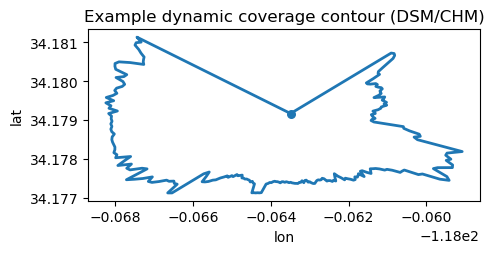

In [19]:
# pick one candidate to visualize its r_eff(θ)
i_test = int(len(packs_dsmchm["candidates"]) // 2)
plot_single_sensor_contour(
    packs_dsmchm["candidates"][i_test],
    packs_dsmchm["dirpacks"][i_test],
    title="Example dynamic coverage contour (DSM/CHM)"
)

In [21]:
# =======================
# Rich AOI + placements map (all scenarios & optimizers)
# =======================
from ipyleaflet import Map, Polygon as LPolygon, CircleMarker, LayerGroup, LayersControl, basemaps, WidgetControl
from ipywidgets import HTML, VBox
from shapely.geometry import Polygon

def _lonlat_to_latlon(coords):
    # [(lon,lat), ...] -> [(lat,lon), ...]
    return [(c[1], c[0]) for c in coords]

def _mk_popup_html(title, rows):
    # rows is list of (label, value)
    html = [f"<b>{title}</b><br>"]
    for k,v in rows:
        html.append(f"<span style='opacity:0.85'>{k}:</span> <b>{v}</b><br>")
    return HTML("".join(html))

def _scenario_name_key(key):
    # normalize short keys to pretty names
    if key.lower() in ("flat",): return "FLAT"
    if key.lower() in ("dem",): return "DEM"
    return "DSM/CHM"

def _ensure_artifacts(packs, sol, SP):
    # Builds sensors+contours if you didn't run build_solution_artifacts
    idxs = list(map(int, sol["idxs"]))
    sensors   = [packs["candidates"][i] for i in idxs]
    dirpacks  = [packs["dirpacks"][i]    for i in idxs]
    contours  = [coverage_contour_lonlat(sensors[i], dirpacks[i], SP) for i in range(len(idxs))]
    df = packs["metrics"].iloc[idxs].copy()
    df["idx"] = idxs
    return {"sensors": sensors, "contours": contours, "df": df, "dirpacks": dirpacks}

def make_layers_for_solution(scn_label, algo_label, packs, sol, color, SP, fill_opacity=0.18, stroke_weight=2):
    """Return a LayerGroup with filled coverage polygons + sensor markers for one (scenario, optimizer) combo."""
    art = _ensure_artifacts(packs, sol, SP)
    group = LayerGroup(name=f"{scn_label} — {algo_label}")

    for i, (coord, ring, dp) in enumerate(zip(art["sensors"], art["contours"], art["dirpacks"])):
        # coverage polygon
        latlon = _lonlat_to_latlon(ring)
        poly = LPolygon(
            locations=latlon,
            color=color,
            fill_color=color,
            fill_opacity=fill_opacity,
            weight=stroke_weight,
            name=f"{scn_label}-{algo_label}-cov-{i}"
        )
        group.add_layer(poly)

        # sensor marker
        gm = float(dp["gamma_mean"])
        Aeff = float(dp["Aeff_m2"])
        r_eff = np.asarray(dp["r_eff"])
        stats = (np.min(r_eff), np.mean(r_eff), np.max(r_eff))
        marker = CircleMarker(
            location=(coord[1], coord[0]),
            radius=5,
            color=color,
            fill_color=color,
            fill_opacity=0.95,
            weight=1,
            name=f"{scn_label}-{algo_label}-pt-{i}"
        )
        popup = _mk_popup_html(
            f"{scn_label} · {algo_label} · sensor #{art['df'].iloc[i]['idx']}",
            [
                ("γ̄ (mean)", f"{gm:.3f}"),
                ("A_eff (m²)", f"{Aeff:,.0f}"),
                ("r_eff (min/mean/max m)", f"{stats[0]:.1f} / {stats[1]:.1f} / {stats[2]:.1f}"),
                ("Coord (lon, lat)", f"{coord[0]:.6f}, {coord[1]:.6f}")
            ]
        )
        marker.popup = popup
        group.add_layer(marker)
    return group

def build_full_placements_map(
    aoi_poly: Polygon,
    packs_flat, res_flat,
    packs_dem,  res_dem,
    packs_chm,  res_chm,
    SP,
    base=basemaps.Esri.WorldImagery
):
    # Colors per scenario
    SCN_COLORS = {
        "FLAT":    "#4C78A8",  # blue
        "DEM":     "#F58518",  # orange
        "DSM/CHM": "#54A24B",  # green
    }
    # Slightly different fill opacities by optimizer to help layering
    OPT_FILL = {"Random": 0.10, "Greedy": 0.18, "NSGA-III": 0.26}

    # Build the map centered on AOI
    cx, cy = aoi_poly.centroid.x, aoi_poly.centroid.y
    m = Map(center=(cy, cx), zoom=13, basemap=base)

    # AOI outline layer
    aoi_latlon = _lonlat_to_latlon(list(aoi_poly.exterior.coords))
    aoi_layer = LPolygon(
        locations=aoi_latlon, color="#FFFFFF", weight=3, fill=False, name="AOI"
    )
    m.add_layer(aoi_layer)

    # Create layers for each scenario x optimizer
    layers = []

    # FLAT
    layers.append(make_layers_for_solution(
        "FLAT", "Random", packs_flat, res_flat["random"], SCN_COLORS["FLAT"], SP, OPT_FILL["Random"]))
    layers.append(make_layers_for_solution(
        "FLAT", "Greedy", packs_flat, res_flat["greedy"], SCN_COLORS["FLAT"], SP, OPT_FILL["Greedy"]))
    layers.append(make_layers_for_solution(
        "FLAT", "NSGA-III", packs_flat, res_flat["nsga"], SCN_COLORS["FLAT"], SP, OPT_FILL["NSGA-III"]))

    # DEM
    layers.append(make_layers_for_solution(
        "DEM", "Random", packs_dem, res_dem["random"], SCN_COLORS["DEM"], SP, OPT_FILL["Random"]))
    layers.append(make_layers_for_solution(
        "DEM", "Greedy", packs_dem, res_dem["greedy"], SCN_COLORS["DEM"], SP, OPT_FILL["Greedy"]))
    layers.append(make_layers_for_solution(
        "DEM", "NSGA-III", packs_dem, res_dem["nsga"], SCN_COLORS["DEM"], SP, OPT_FILL["NSGA-III"]))

    # DSM/CHM
    layers.append(make_layers_for_solution(
        "DSM/CHM", "Random", packs_chm, res_chm["random"], SCN_COLORS["DSM/CHM"], SP, OPT_FILL["Random"]))
    layers.append(make_layers_for_solution(
        "DSM/CHM", "Greedy", packs_chm, res_chm["greedy"], SCN_COLORS["DSM/CHM"], SP, OPT_FILL["Greedy"]))
    layers.append(make_layers_for_solution(
        "DSM/CHM", "NSGA-III", packs_chm, res_chm["nsga"], SCN_COLORS["DSM/CHM"], SP, OPT_FILL["NSGA-III"]))

    for lg in layers:
        m.add_layer(lg)

    # Layer control
    m.add_control(LayersControl(position="topright"))

    # Legend widget (sticky)
    legend_html = HTML(
        """
        <div style="background: rgba(0,0,0,0.55); color: white; padding: 10px 12px; font-size: 12px; border-radius: 8px;">
          <div style="font-weight:600; margin-bottom:6px;">Sensor Placements</div>
          <div><span style="display:inline-block;width:12px;height:12px;background:#4C78A8;margin-right:6px;border-radius:2px;"></span>FLAT</div>
          <div><span style="display:inline-block;width:12px;height:12px;background:#F58518;margin-right:6px;border-radius:2px;"></span>DEM</div>
          <div><span style="display:inline-block;width:12px;height:12px;background:#54A24B;margin-right:6px;border-radius:2px;"></span>DSM/CHM</div>
          <hr style="border-color: rgba(255,255,255,0.25)">
          <div style="opacity:0.9;"><b>Layers:</b> toggle any combo</div>
          <div style="opacity:0.8;">Random = light fill · Greedy = medium · NSGA-III = darkest</div>
          <div style="opacity:0.8;">Click a sensor for γ̄, A<sub>eff</sub>, r<sub>eff</sub> stats.</div>
        </div>
        """
    )
    m.add_control(WidgetControl(widget=legend_html, position="bottomleft"))

    # Fit to AOI bounds
    (minx, miny, maxx, maxy) = aoi_poly.bounds
    m.fit_bounds([(miny, minx), (maxy, maxx)])

    return m

# ==== Build and display the big map ====
big_map = build_full_placements_map(
    aoi_poly,
    packs_flat, res_flat,
    packs_dem,  res_dem,
    packs_dsmchm, res_dsmchm,
    SP
)
display(big_map)

Map(center=[34.20220505555384, -118.06451005555147], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [22]:
# Debug: Check what surfaces are being used
print("=== SURFACE DEBUG ===")
print(f"DEM available: {dem_manager.dem_utm is not None}")
print(f"DSM available: {dem_manager.dsm_utm is not None}")  
print(f"CHM available: {dem_manager.chm_utm is not None}")

if dem_manager.dsm_utm is not None and dem_manager.dem_utm is not None:
    # Sample a few points to see the difference
    test_points = [(100, 100), (500, 500), (1000, 1000)]
    for x, y in test_points:
        dem_val = _bilinear(dem_manager.dem_utm, dem_manager.utm_transform, x, y)
        dsm_val = _bilinear(dem_manager.dsm_utm, dem_manager.utm_transform, x, y)
        chm_val = _bilinear(dem_manager.chm_utm, dem_manager.utm_transform, x, y)
        print(f"Point ({x},{y}): DEM={dem_val:.1f}m, DSM={dsm_val:.1f}m, CHM={chm_val:.1f}m")

=== SURFACE DEBUG ===
DEM available: True
DSM available: True
CHM available: True
Point (100,100): DEM=nanm, DSM=nanm, CHM=nanm
Point (500,500): DEM=nanm, DSM=nanm, CHM=nanm
Point (1000,1000): DEM=nanm, DSM=nanm, CHM=nanm


In [23]:
# Pick the same sensor location and compare scenarios
test_coord = packs_dem["candidates"][0]  # First candidate
print(f"\n=== SENSOR DEBUG: {test_coord} ===")

dp_dem = directional_gamma(dem_manager, test_coord, "dem", SP)
dp_dsm = directional_gamma(dem_manager, test_coord, "dsm_chm", SP)

print(f"DEM scenario:     γ̄={dp_dem['gamma_mean']:.3f}, A_eff={dp_dem['Aeff_m2']:.0f}")
print(f"DSM/CHM scenario: γ̄={dp_dsm['gamma_mean']:.3f}, A_eff={dp_dsm['Aeff_m2']:.0f}")

# Look at a few azimuth directions
for i in range(0, len(dp_dem['az']), 45):  # Every 45 degrees
    az = dp_dem['az'][i]
    print(f"  Az {az:3.0f}°: DEM γ={dp_dem['gamma_az'][i]:.3f}, DSM/CHM γ={dp_dsm['gamma_az'][i]:.3f}")


=== SENSOR DEBUG: (-118.09202114176217, 34.17916759003501) ===
DEM scenario:     γ̄=0.479, A_eff=376205
DSM/CHM scenario: γ̄=0.281, A_eff=220441
  Az   0°: DEM γ=1.000, DSM/CHM γ=0.567
  Az  45°: DEM γ=0.187, DSM/CHM γ=0.334
  Az  90°: DEM γ=1.000, DSM/CHM γ=0.584
  Az 135°: DEM γ=0.516, DSM/CHM γ=0.270
  Az 180°: DEM γ=0.258, DSM/CHM γ=0.183
  Az 225°: DEM γ=0.360, DSM/CHM γ=0.192
  Az 270°: DEM γ=0.180, DSM/CHM γ=0.090
  Az 315°: DEM γ=0.360, DSM/CHM γ=0.189


In [24]:
# Test vegetation calculation directly
test_coord = packs_dem["candidates"][10]  # Pick one in vegetated area
az, g_veg, V = vegetation_gamma_az(dem_manager, test_coord, SP)

print(f"\n=== VEGETATION DEBUG ===")
print(f"Vegetation density V: min={np.min(V):.3f}, mean={np.mean(V):.3f}, max={np.max(V):.3f}")
print(f"Vegetation gamma: min={np.min(g_veg):.3f}, mean={np.mean(g_veg):.3f}, max={np.max(g_veg):.3f}")
print(f"Should be < 1.0 if vegetation present!")


=== VEGETATION DEBUG ===
Vegetation density V: min=0.301, mean=0.602, max=0.867
Vegetation gamma: min=0.458, mean=0.586, max=0.763
Should be < 1.0 if vegetation present!


In [25]:
# Debug vegetation per direction
test_coord = packs_dem["candidates"][0]
x0, y0 = dem_manager._ll2utm.transform(test_coord[0], test_coord[1])

print("\n=== PER-DIRECTION VEGETATION DEBUG ===")
az = np.arange(0, 360, SP.az_step_deg, dtype=float)
steps = max(2, int(SP.R_m // SP.step_m))
s = np.linspace(SP.step_m, steps*SP.step_m, steps, dtype=float)
vx = np.sin(np.deg2rad(az)); vy = np.cos(np.deg2rad(az))

for i in [0, 4, 18, 27, 36, 45, 54, 63]:  # Sample 8 directions
    xs = x0 + vx[i] * s
    ys = y0 + vy[i] * s
    
    # Check terrain blocking
    z_s = np.array([elev_surface_at_utm(dem_manager, xs[k], ys[k], "dem") for k in range(len(xs))])
    z0 = elev_surface_at_utm(dem_manager, x0, y0, "dem") + SP.sensor_height_m
    alpha = np.degrees(np.arctan2(z_s - z0, s))
    
    ok = np.where(alpha <= SP.theta_topo_deg)[0]
    r_open = float(s[ok[-1]]) if ok.size > 0 else 0.0
    
    # Check vegetation in visible area
    if r_open > 0:
        ch = np.array([_bilinear(dem_manager.chm_utm, dem_manager.utm_transform, xs[k], ys[k]) for k in range(len(xs))])
        ch = np.nan_to_num(ch, nan=0.0)
        use = (s <= r_open) & (ch >= SP.h_thr_m)
        veg_count = np.sum(use)
        avg_veg_height = np.mean(ch[use]) if veg_count > 0 else 0
    else:
        veg_count = 0
        avg_veg_height = 0
    
    print(f"Az {az[i]:3.0f}°: r_open={r_open:4.0f}m, veg_pixels={veg_count:2d}, avg_height={avg_veg_height:.1f}m")


=== PER-DIRECTION VEGETATION DEBUG ===
Az   0°: r_open= 500m, veg_pixels=178, avg_height=6.1m
Az   4°: r_open= 474m, veg_pixels=195, avg_height=6.3m
Az  18°: r_open= 160m, veg_pixels=67, avg_height=4.8m
Az  27°: r_open= 176m, veg_pixels=69, avg_height=6.3m
Az  36°: r_open= 185m, veg_pixels=78, avg_height=5.8m
Az  45°: r_open= 236m, veg_pixels=97, avg_height=4.5m
Az  54°: r_open= 369m, veg_pixels=207, avg_height=4.8m
Az  63°: r_open= 500m, veg_pixels=225, avg_height=5.2m


In [ ]:
# === DIRECT FUNCTION CALL DEBUG ===
test_coord = packs_dem["candidates"][0]
x0, y0 = dem_manager._ll2utm.transform(test_coord[0], test_coord[1])

# Call the actual function
az_full, gamma_full, g_topo_full, horizon_full = horizon_and_veg_profiles_utm(dem_manager, x0, y0, SP, mode="dsm_chm")

print(f"\n=== FUNCTION RESULTS ===")
for i in [0, 22, 45, 67, 90]:  # Every ~45 degrees worth
    if i < len(az_full):
        print(f"Az {az_full[i]:3.0f}°: gamma={gamma_full[i]:.3f}, g_topo={g_topo_full[i]:.3f}")

# Calculate g_veg from gamma and g_topo
print(f"\n=== DERIVED g_veg VALUES ===")
for i in [0, 22, 45, 67, 90]:
    if i < len(az_full) and g_topo_full[i] > 0:
        g_veg_derived = gamma_full[i] / g_topo_full[i]
        print(f"Az {az_full[i]:3.0f}°: g_veg = {gamma_full[i]:.3f} / {g_topo_full[i]:.3f} = {g_veg_derived:.3f}")
    else:
        print(f"Az {az_full[i]:3.0f}°: g_topo=0, can't derive g_veg")

# === SMOKING GUN TEST ===
# Compare DEM vs DSM/CHM for the SAME coordinate
print(f"\n=== DIRECT SCENARIO COMPARISON ===")
dp_dem = directional_gamma(dem_manager, test_coord, "dem", SP)
dp_dsm = directional_gamma(dem_manager, test_coord, "dsm_chm", SP)

print("First 10 azimuth comparisons:")
for i in range(10):
    az = dp_dem['az'][i]
    dem_gamma = dp_dem['gamma_az'][i] 
    dsm_gamma = dp_dsm['gamma_az'][i]
    diff = abs(dem_gamma - dsm_gamma)
    print(f"Az {az:3.0f}°: DEM={dem_gamma:.3f}, DSM/CHM={dsm_gamma:.3f}, diff={diff:.3f}")


=== FUNCTION RESULTS ===
Az   0°: gamma=0.597, g_topo=1.000
Az  22°: gamma=0.484, g_topo=0.854
Az  45°: gamma=0.000, g_topo=0.000
Az  67°: gamma=0.000, g_topo=0.000
Az  90°: gamma=0.000, g_topo=0.000

=== DERIVED g_veg VALUES ===
Az   0°: g_veg = 0.597 / 1.000 = 0.597
Az  22°: g_veg = 0.484 / 0.854 = 0.567
Az  45°: g_veg = 0.000 / 0.000 = 1.000
Az  67°: g_veg = 0.000 / 0.000 = 1.000
Az  90°: g_veg = 0.000 / 0.000 = 1.000

=== DIRECT SCENARIO COMPARISON ===
First 10 azimuth comparisons:
Az   0°: DEM=1.000, DSM/CHM=0.597, diff=0.403
Az   1°: DEM=1.000, DSM/CHM=0.604, diff=0.396
Az   2°: DEM=1.000, DSM/CHM=0.605, diff=0.395
Az   3°: DEM=1.000, DSM/CHM=0.589, diff=0.411
Az   4°: DEM=1.000, DSM/CHM=0.596, diff=0.404
Az   5°: DEM=1.000, DSM/CHM=0.577, diff=0.423
Az   6°: DEM=1.000, DSM/CHM=0.602, diff=0.398
Az   7°: DEM=1.000, DSM/CHM=0.590, diff=0.410
Az   8°: DEM=1.000, DSM/CHM=0.589, diff=0.411
Az   9°: DEM=1.000, DSM/CHM=0.580, diff=0.420
